In [ ]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import vgg16

from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.inspection import DecisionBoundaryDisplay
import warnings
warnings.filterwarnings("ignore")

In [ ]:
MainFolder = '/content/drive/MyDrive/AfsharBreastCancer/'
ResultsFolder = MainFolder + 'Results/'
DatasetFolder = MainFolder + 'Dataset/'
NegativeFolder = DatasetFolder + 'Negative/'
CanserFolder = DatasetFolder + 'Cancer/'
ClassNames = ['Negative', 'Cancer']
FeaturesFile = DatasetFolder + 'Features.p'
DataReadyFile = DatasetFolder + 'DataReady.p'
ResultsFile = ResultsFolder + 'Results.p'

In [ ]:
def GetFeatures(ImageFile, InputSize):
    img = image.load_img(ImageFile, target_size=InputSize)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = PreprocessInput(x)
    return np.array(model(x)).flatten()

if os.path.isfile(FeaturesFile):
    with open(FeaturesFile, 'rb') as f:
        Features, Labels, FileNames = pickle.load(f)
    print('Features loaded.')

else:

    Features = []
    Labels = []
    FileNames = []
    model = vgg16.VGG16(weights='imagenet', include_top=False, pooling='max')
    PreprocessInput = vgg16.preprocess_input
    InputSize = (224,224)
    
    NegativeFiles = [NegativeFolder + f for f in os.listdir(NegativeFolder)]
    CanserFiles  = [CanserFolder + f for f in os.listdir(CanserFolder)]

    print('Negative Files:', len(NegativeFiles))
    for i, ImageFile in enumerate(NegativeFiles):
        Features.append(GetFeatures(ImageFile, InputSize))
        Labels.append(0)
        FileNames.append(ImageFile)
        print(i, end=',')

    print('\nCanser Files:', len(CanserFiles))
    for i, ImageFile in enumerate(CanserFiles):
        Features.append(GetFeatures(ImageFile, InputSize))
        Labels.append(1)
        FileNames.append(ImageFile)
        print(i, end=',')      

    with open(FeaturesFile, 'wb') as f:
        pickle.dump([Features, Labels, FileNames], f)

Features loaded.


In [ ]:
if os.path.isfile(DataReadyFile):
    with open(DataReadyFile, 'rb') as f:
        XTrain, XTest, YTrain, YTest = pickle.load(f)
    print('Data loaded.')

else:
    X = np.vstack(Features)
    Y = np.hstack(Labels)
    XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.2, random_state=42)
    with open(DataReadyFile, 'wb') as f:
        pickle.dump([XTrain, XTest, YTrain, YTest], f)

print(XTrain.shape, YTrain.shape, np.unique(YTrain, return_counts=True))
print(XTest.shape, YTest.shape, np.unique(YTest, return_counts=True))

pca = PCA(n_components=2)
pca.fit(XTrain)
XTrainPca = pca.transform(XTrain)  
XTestPca = pca.transform(XTest) 

Data loaded.
(656, 512) (656,) (array([0, 1]), array([328, 328]))
(164, 512) (164,) (array([0, 1]), array([82, 82]))


Text(0.5, 1.0, 'PCA')

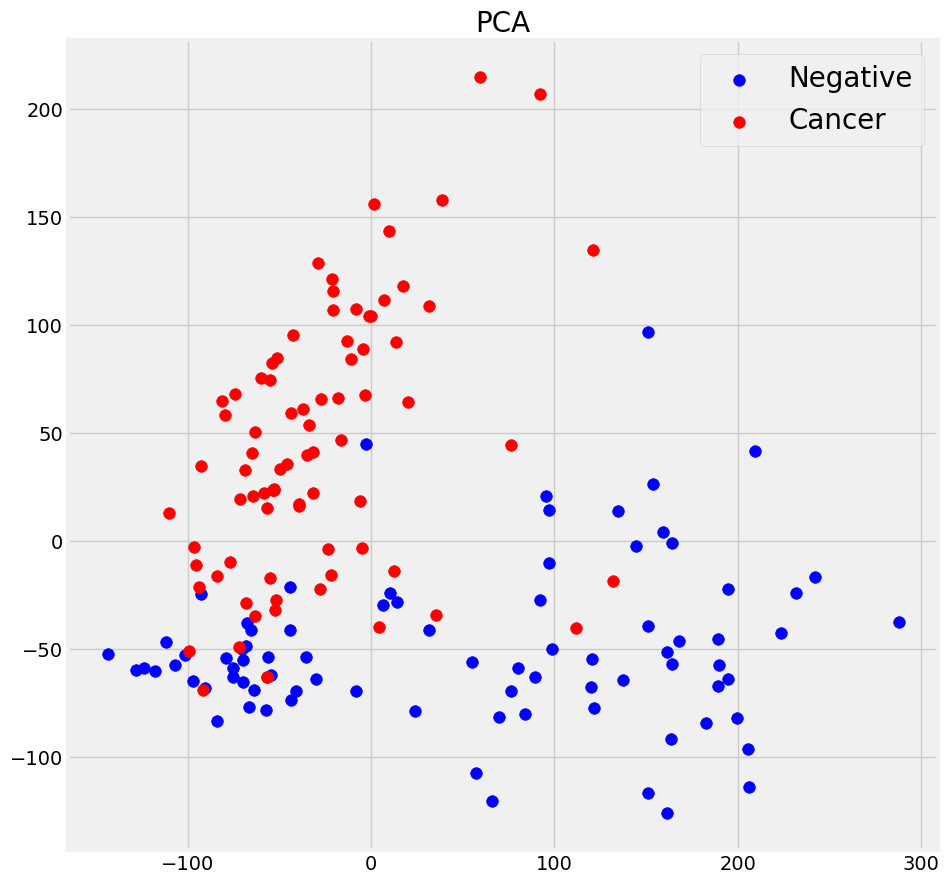

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10), facecolor='w')
PointSize = 70

Marker = 'o' #'s'
XPlt = XTestPca[YTest == 0, :]
plt.scatter(XPlt[:, 0], XPlt[:, 1], alpha=1, color='b', label=0, marker=Marker, s=PointSize)
XPlt = XTestPca[YTest == 1, :]
plt.scatter(XPlt[:, 0], XPlt[:, 1], alpha=1, color='r', label=1, marker=Marker, s=PointSize)   
    
plt.legend(ClassNames, scatterpoints=1, loc='upper right', ncol=1, fontsize=20)

plt.tick_params(labelsize=14)  
# plt.xlim([-10,10])
# plt.ylim([-10,10])
# plt.axis('off')
plt.savefig(ResultsFolder + 'PCA.pdf')
plt.title('PCA', fontdict={'fontsize': 20})

In [ ]:
Classifiers = [
              {'Name': "Nearest Neighbors", 'Clf': KNeighborsClassifier(2)},
              {'Name': "Linear SVM", 'Clf': SVC(kernel="linear", C=0.025, probability=True)},
              {'Name': "RBF SVM", 'Clf': SVC(gamma=0.0013, C=2, probability=True)},
              {'Name': "Gaussian Process", 'Clf': GaussianProcessClassifier(1 * RBF(1))},
              {'Name': "Random Forest", 'Clf': RandomForestClassifier(max_depth=100, n_estimators=1000, max_features=2)},
            #   {'Name': "DecisionTree", 'Clf': tree.DecisionTreeClassifier()},
              {'Name': "Neural Net", 'Clf': MLPClassifier(alpha=1, max_iter=100)},
              {'Name': "AdaBoost", 'Clf': AdaBoostClassifier()},
              {'Name': "Naive Bayes", 'Clf': GaussianNB()},
              ]

Nearest Neighbors: 0.86
Linear SVM: 0.88
RBF SVM: 0.90
Gaussian Process: 0.92
Random Forest: 0.93
Neural Net: 0.88
AdaBoost: 0.90
Naive Bayes: 0.88


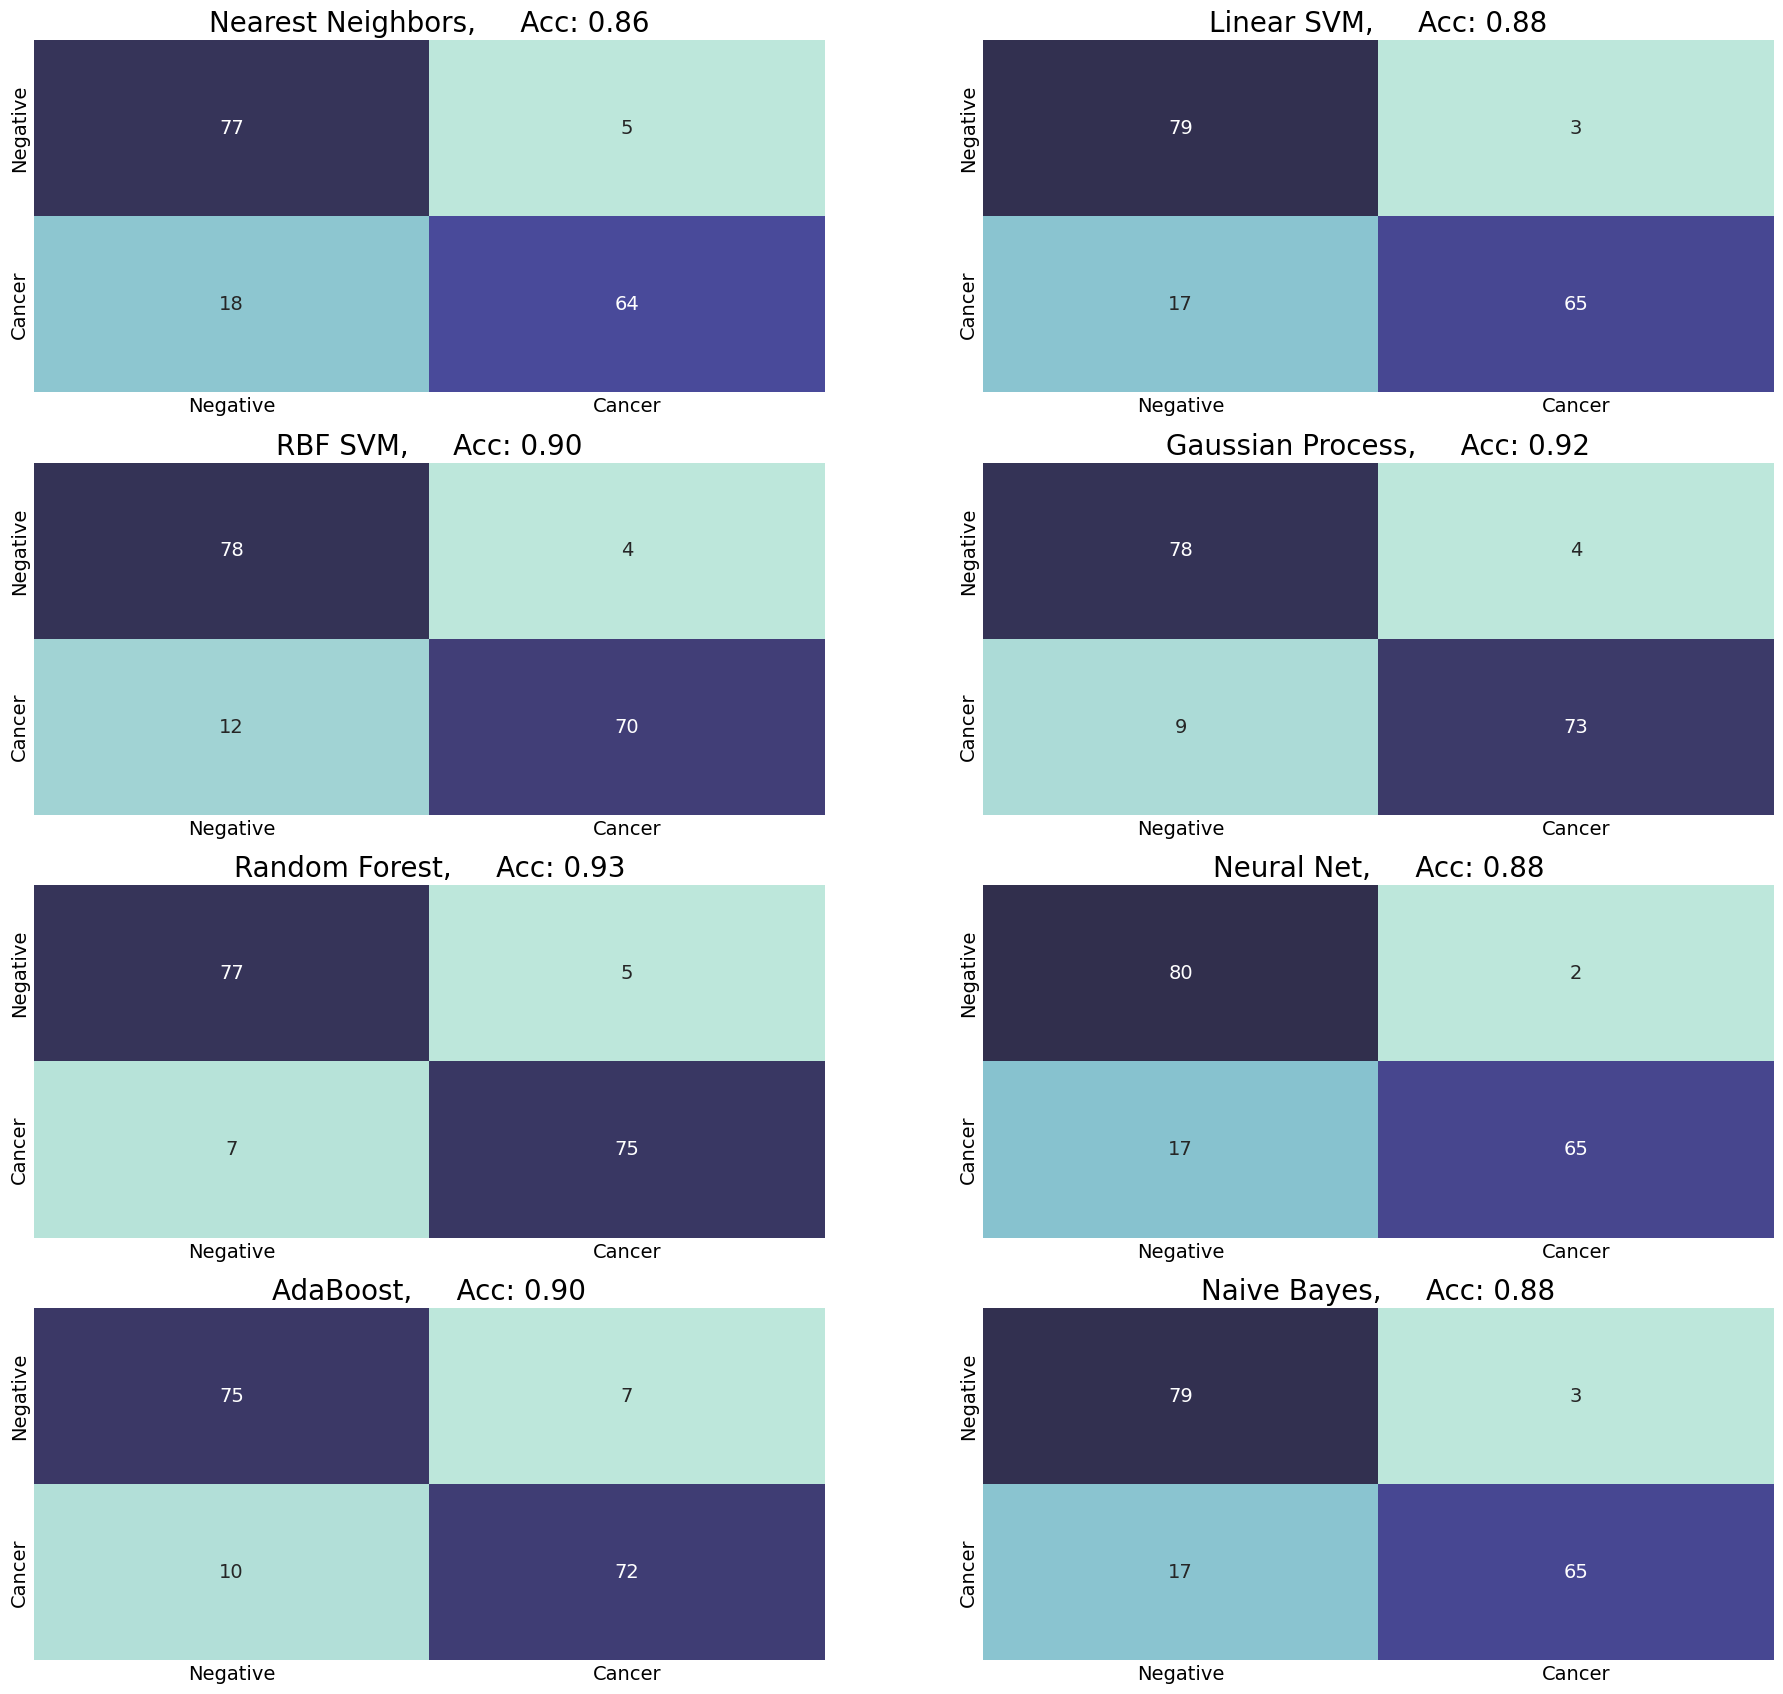

In [ ]:
plt.style.use('fivethirtyeight')


fig, axes = plt.subplots(4, 2, figsize=(20, 20), facecolor='w')
plt.title('Confusion Matrix')

for ClfIdx, Classifier in enumerate(Classifiers):
    ClfName = Classifier['Name']
    Clf     = Classifier['Clf']
    p, q = int(ClfIdx / 2), int(ClfIdx % 2)
    Clf.fit(XTrainPca, YTrain)   
    YPred = Clf.predict(XTestPca)
    Acc = accuracy_score(YTest, YPred)
    CM = confusion_matrix(YTest, YPred)
    print('%s: %0.2f' % (ClfName, Acc))
    
    sns.heatmap(CM, ax=axes[p,q], annot=True, xticklabels=ClassNames,yticklabels=ClassNames, cbar=False, center=100)    
    axes[p,q].set_title('%s,     Acc: %0.2f' % (ClfName, Acc), fontdict={'fontsize': 20})
    

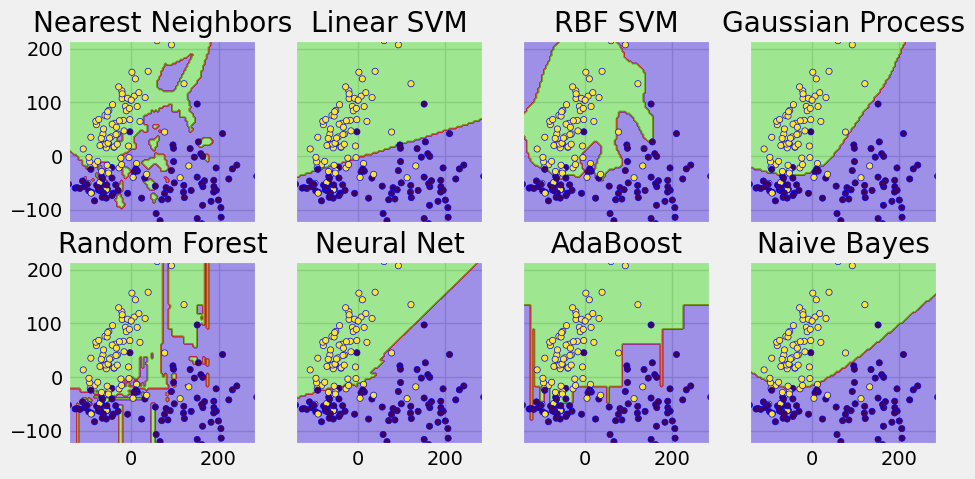

In [ ]:
plt.style.use('fivethirtyeight')
ClfNames = []
Clfs = []
for ClfIdx, Classifier in enumerate(Classifiers):
    ClfName = Classifier['Name']
    Clf     = Classifier['Clf']
    ClfNames.append(ClfName)
    Clfs.append(Clf)

f, axarr = plt.subplots(2, 4, sharex="col", sharey="row", figsize=(10, 5))
Idxs = [[0,0],[0,1],[0,2],[0,3],[1,0],[1,1],[1,2],[1,3]]
for idx, clf, tt in zip(Idxs, Clfs, ClfNames):
    DecisionBoundaryDisplay.from_estimator(clf, XTestPca, alpha=0.4, cmap="brg" ,ax=axarr[idx[0], idx[1]], response_method="predict")
    axarr[idx[0], idx[1]].scatter(XTestPca[:, 0], XTestPca[:, 1], c=YTest, s=20, edgecolor="b")
    axarr[idx[0], idx[1]].set_title(tt)

In [ ]:
Results = []

if os.path.isfile(ResultsFile):
    Results = pd.read_csv(ResultsFile)

else:
    for i in range(30):    
        print(i, end=',')

        X = np.vstack(Features)
        Y = np.hstack(Labels)
        XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.2)
        pca = PCA(n_components=100)
        pca.fit(XTrain)
        XTrainPca = pca.transform(XTrain)  
        XTestPca = pca.transform(XTest) 

        for ClfIdx, Classifier in enumerate(Classifiers):
            ClfName = Classifier['Name']
            Clf     = Classifier['Clf']
            p, q = int(ClfIdx / 2), int(ClfIdx % 2)
            Clf.fit(XTrainPca, YTrain)   
            YPred = Clf.predict(XTestPca)

            Accuracy = accuracy_score(YTest, YPred)
            Precision = precision_score(YTest, YPred)
            Recall = recall_score(YTest, YPred)
            F1 = 2 * (Precision * Recall) / (Precision + Recall)
            [TN, FP], [FN, TP] = confusion_matrix(YTest, YPred)
            Sensitivity  = TP / (TP + FN)
            Specificity = TN / (TN + FP)

            Results.append({'ClfName': ClfName, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall,
                        'F1': F1, 'Sensitivity': Sensitivity, 'Specificity': Specificity})  
            
    Results = pd.DataFrame(Results)

Results.to_csv(ResultsFile, index=False)

In [ ]:
Results

,ClfName,Accuracy,Precision,Recall,F1,Sensitivity,Specificity
0,Nearest Neighbors,0.884146,0.943662,0.817073,0.875817,0.817073,0.951220
1,Linear SVM,0.920732,0.905882,0.939024,0.922156,0.939024,0.902439
2,RBF SVM,0.530488,1.000000,0.060976,0.114943,0.060976,1.000000
3,Gaussian Process,0.530488,1.000000,0.060976,0.114943,0.060976,1.000000
4,Random Forest,0.914634,0.904762,0.926829,0.915663,0.926829,0.902439
...,...,...,...,...,...,...,...
235,Gaussian Process,0.524390,1.000000,0.071429,0.133333,0.071429,1.000000
236,Random Forest,0.945122,0.962963,0.928571,0.945455,0.928571,0.962500
237,Neural Net,0.914634,0.926829,0.904762,0.915663,0.904762,0.925000
238,AdaBoost,0.945122,0.962963,0.928571,0.945455,0.928571,0.962500


In [ ]:
df = pd.DataFrame(columns =['classification','Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']) 

In [ ]:
df

,classification,Accuracy,Precision,Recall,F1,Sensitivity,Specificity


Nearest Neighbors
Accuracy: 91.10 +/- 2.18
Precision: 97.46 +/- 1.81
Recall: 84.72 +/- 3.86
F1: 90.60 +/- 2.38
Specificity: 97.64 +/- 1.90


Linear SVM
Accuracy: 94.90 +/- 1.88
Precision: 94.92 +/- 2.55
Recall: 95.06 +/- 2.66
F1: 94.96 +/- 1.91
Specificity: 94.59 +/- 3.25


RBF SVM
Accuracy: 51.26 +/- 4.36
Precision: 92.61 +/- 19.17
Recall: 20.43 +/- 31.81
F1: 21.28 +/- 16.46
Specificity: 86.70 +/- 34.48


Gaussian Process
Accuracy: 53.15 +/- 4.11
Precision: 100.00 +/- 0.00
Recall: 8.09 +/- 2.13
F1: 14.90 +/- 3.63
Specificity: 100.00 +/- 0.00


Random Forest
Accuracy: 93.78 +/- 1.88
Precision: 93.77 +/- 3.54
Recall: 94.09 +/- 3.14
F1: 93.85 +/- 2.03
Specificity: 93.67 +/- 3.36


Neural Net
Accuracy: 93.56 +/- 2.32
Precision: 93.61 +/- 2.75
Recall: 93.74 +/- 3.27
F1: 93.64 +/- 2.36
Specificity: 93.22 +/- 3.43


AdaBoost
Accuracy: 93.25 +/- 2.07
Precision: 93.60 +/- 3.16
Recall: 93.16 +/- 2.69
F1: 93.33 +/- 2.09
Specificity: 93.30 +/- 3.60


Naive Bayes
Accuracy: 75.02 +/- 3.74
Precision

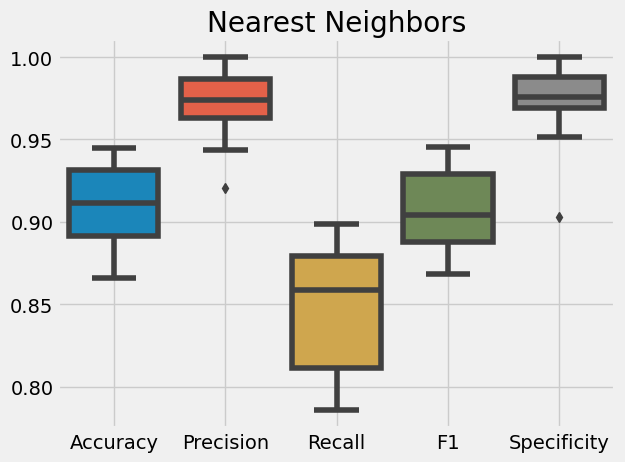

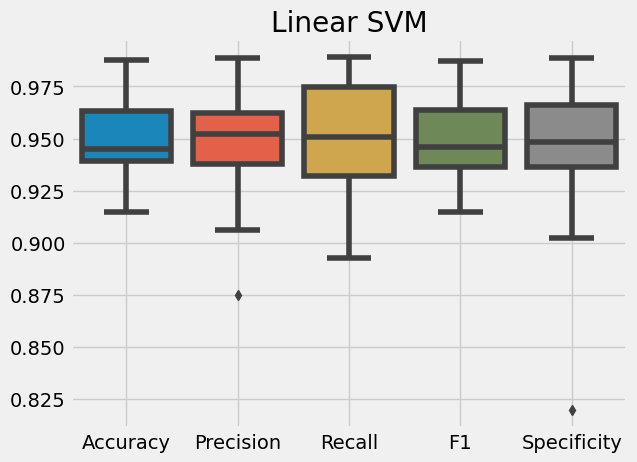

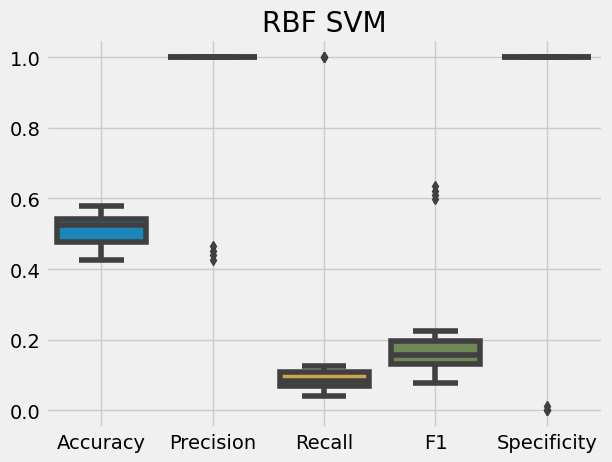

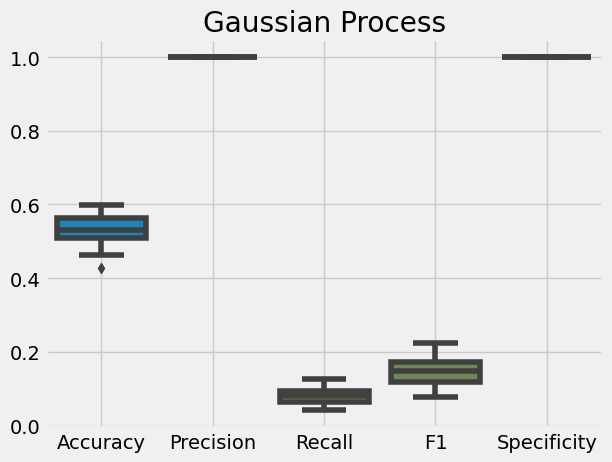

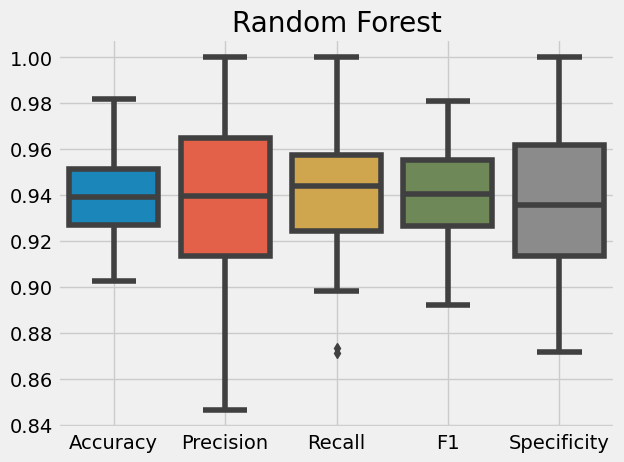

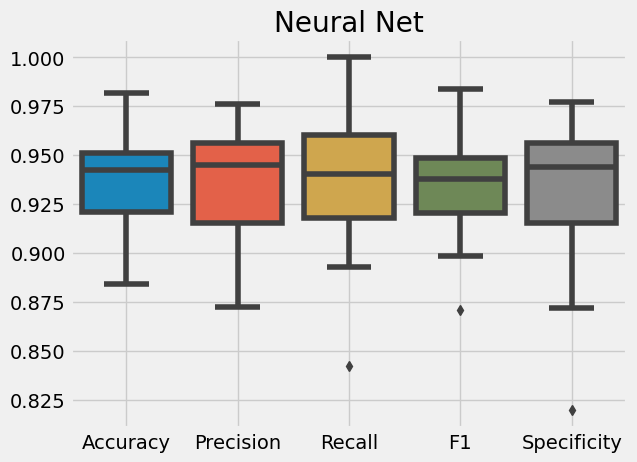

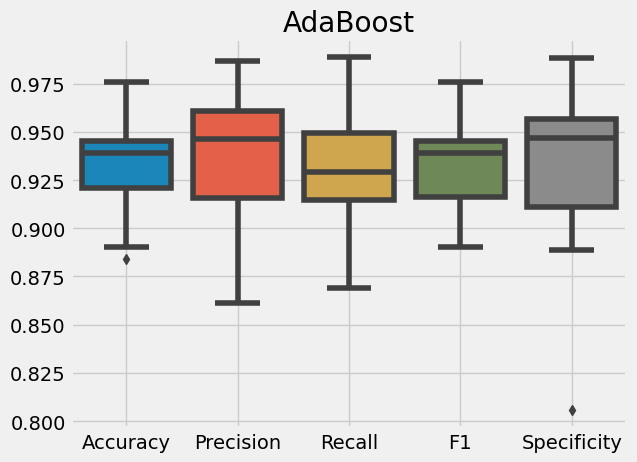

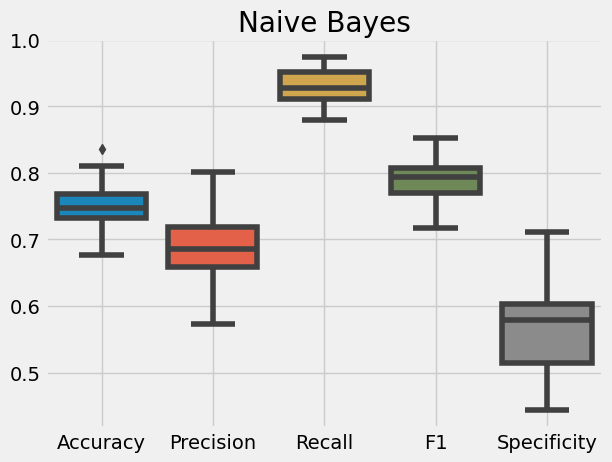

In [ ]:
plt.style.use('fivethirtyeight')

Metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']
Clf=[]
for ClfIdx, Classifier in enumerate(Classifiers):
    ClfName = Classifier['Name']
    print(ClfName)
    Clf.append(ClfName)
    R = Results[Results.ClfName == ClfName]
    a=[]
    for Metric in Metrics:
        R[Metric]
        print('%s: %0.2f +/- %0.2f' % (Metric, R[Metric].mean()*100 , R[Metric].std()*100)) 
        a.append(f'{R[Metric].mean()*100:.2f} +/- {R[Metric].std()*100:.2f}') 
    b =  [ClfName] + a  
    df.loc[ClfName] = b
    print('\n')
    plt.figure()
    sns.boxplot(data=R[Metrics])
    plt.title(ClfName)
    plt.grid(True)
    

In [ ]:
df

,classification,Accuracy,Precision,Recall,F1,Specificity
Nearest Neighbors,Nearest Neighbors,91.10 +/- 2.18,97.46 +/- 1.81,84.72 +/- 3.86,90.60 +/- 2.38,97.64 +/- 1.90
Linear SVM,Linear SVM,94.90 +/- 1.88,94.92 +/- 2.55,95.06 +/- 2.66,94.96 +/- 1.91,94.59 +/- 3.25
RBF SVM,RBF SVM,51.26 +/- 4.36,92.61 +/- 19.17,20.43 +/- 31.81,21.28 +/- 16.46,86.70 +/- 34.48
Gaussian Process,Gaussian Process,53.15 +/- 4.11,100.00 +/- 0.00,8.09 +/- 2.13,14.90 +/- 3.63,100.00 +/- 0.00
Random Forest,Random Forest,93.78 +/- 1.88,93.77 +/- 3.54,94.09 +/- 3.14,93.85 +/- 2.03,93.67 +/- 3.36
Neural Net,Neural Net,93.56 +/- 2.32,93.61 +/- 2.75,93.74 +/- 3.27,93.64 +/- 2.36,93.22 +/- 3.43
AdaBoost,AdaBoost,93.25 +/- 2.07,93.60 +/- 3.16,93.16 +/- 2.69,93.33 +/- 2.09,93.30 +/- 3.60
Naive Bayes,Naive Bayes,75.02 +/- 3.74,68.92 +/- 4.90,93.08 +/- 2.60,79.09 +/- 3.36,56.34 +/- 6.61


In [ ]:
df.to_latex(index = False)

'\\begin{tabular}{llllll}\n\\toprule\n   classification &       Accuracy &       Precision &          Recall &              F1 &     Specificity \\\\\n\\midrule\nNearest Neighbors & 91.10 +/- 2.18 &  97.46 +/- 1.81 &  84.72 +/- 3.86 &  90.60 +/- 2.38 &  97.64 +/- 1.90 \\\\\n       Linear SVM & 94.90 +/- 1.88 &  94.92 +/- 2.55 &  95.06 +/- 2.66 &  94.96 +/- 1.91 &  94.59 +/- 3.25 \\\\\n          RBF SVM & 51.26 +/- 4.36 & 92.61 +/- 19.17 & 20.43 +/- 31.81 & 21.28 +/- 16.46 & 86.70 +/- 34.48 \\\\\n Gaussian Process & 53.15 +/- 4.11 & 100.00 +/- 0.00 &   8.09 +/- 2.13 &  14.90 +/- 3.63 & 100.00 +/- 0.00 \\\\\n    Random Forest & 93.78 +/- 1.88 &  93.77 +/- 3.54 &  94.09 +/- 3.14 &  93.85 +/- 2.03 &  93.67 +/- 3.36 \\\\\n       Neural Net & 93.56 +/- 2.32 &  93.61 +/- 2.75 &  93.74 +/- 3.27 &  93.64 +/- 2.36 &  93.22 +/- 3.43 \\\\\n         AdaBoost & 93.25 +/- 2.07 &  93.60 +/- 3.16 &  93.16 +/- 2.69 &  93.33 +/- 2.09 &  93.30 +/- 3.60 \\\\\n      Naive Bayes & 75.02 +/- 3.74 &  68.92 +/-